In [1]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 364
BATCH_SIZE   = 16
NUM_CLASSES  = 5

pre_process = "ben_colour_"
CHANNEL_SIZE = 3

# pre_process = "ben_green_"
# CHANNEL_SIZE = 1
# pre_process = "clahe_green_"
# CHANNEL_SIZE = 3


Using TensorFlow backend.


# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

           id_code  diagnosis          original                    processed
2929  cb28adab4e8a          0  cb28adab4e8a.png  ben_colour_cb28adab4e8a.png
2930  cb2f3c5d71a7          1  cb2f3c5d71a7.png  ben_colour_cb2f3c5d71a7.png
2931  cb39761f0712          0  cb39761f0712.png  ben_colour_cb39761f0712.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


Text(0.5, 1.0, 'Samples Per Class')

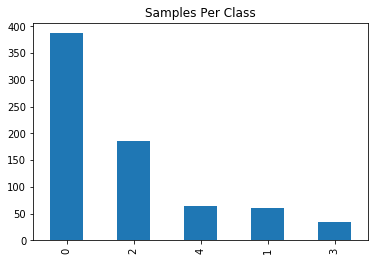

In [2]:
# data frame of current competition
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2019.processed = df_2019.id_code.apply(lambda x: pre_process + x + ".png")
df_2019["original"]  = df_2019.id_code.apply(lambda x: x + ".png")
df_2019["processed"] = df_2019.original.apply(lambda x: pre_process + x)
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False)

# 2019 data frame 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2015["original"]  = df_2015.image.apply(lambda x: x + ".jpeg")
df_2015["processed"] = df_2015.original.apply(lambda x: pre_process + x)
df_2015["diagnosis"] = df_2015.level
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)

valid_2019['diagnosis'].value_counts().plot(kind='bar')
print(valid_2019[:3])
plt.title('Samples Per Class')

In [3]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    return y_val

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x + 1)])
    valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x + 1)])

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == diagnosis].index
            indexes_train = train[train['diagnosis'] == diagnosis].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution
    train = train.sample(frac=0.8)
    valid = valid.sample(frac=0.8)
    
    return train, valid


In [4]:
# # display some data
# def display_data():
#     df_example, _ = get_train_valid_df(year="2019")

#     # Display some random images from Data Set with class categories.
#     figure=plt.figure(figsize=(22,20))
#     for target_class in range(5):
#         for i, file_name in enumerate(df_example[df_example.diagnosis == target_class].original.sample(2)):
            
#             # open the file
#             o_img = cv2.imread(f"../aptos2019/train_images/{file_name}")
#             p_img = cv2.imread(f"../aptos2019/train_images/{pre_process}{file_name}")

#             o_rgb = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
#             p_rgb = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            
#             ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
#             plt.imshow(o_rgb)
#             ax.set_title(target_class)
            
#             ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
#             plt.imshow(p_rgb)
#             ax.set_title(target_class)
            
# display_data()

In [5]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(800*jitter),
                                       brightness_range=[1-jitter, 1+jitter],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[(1-jitter), (1+jitter/2)],
                                       fill_mode="reflect",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="processed", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen

gc.collect()


29

Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.


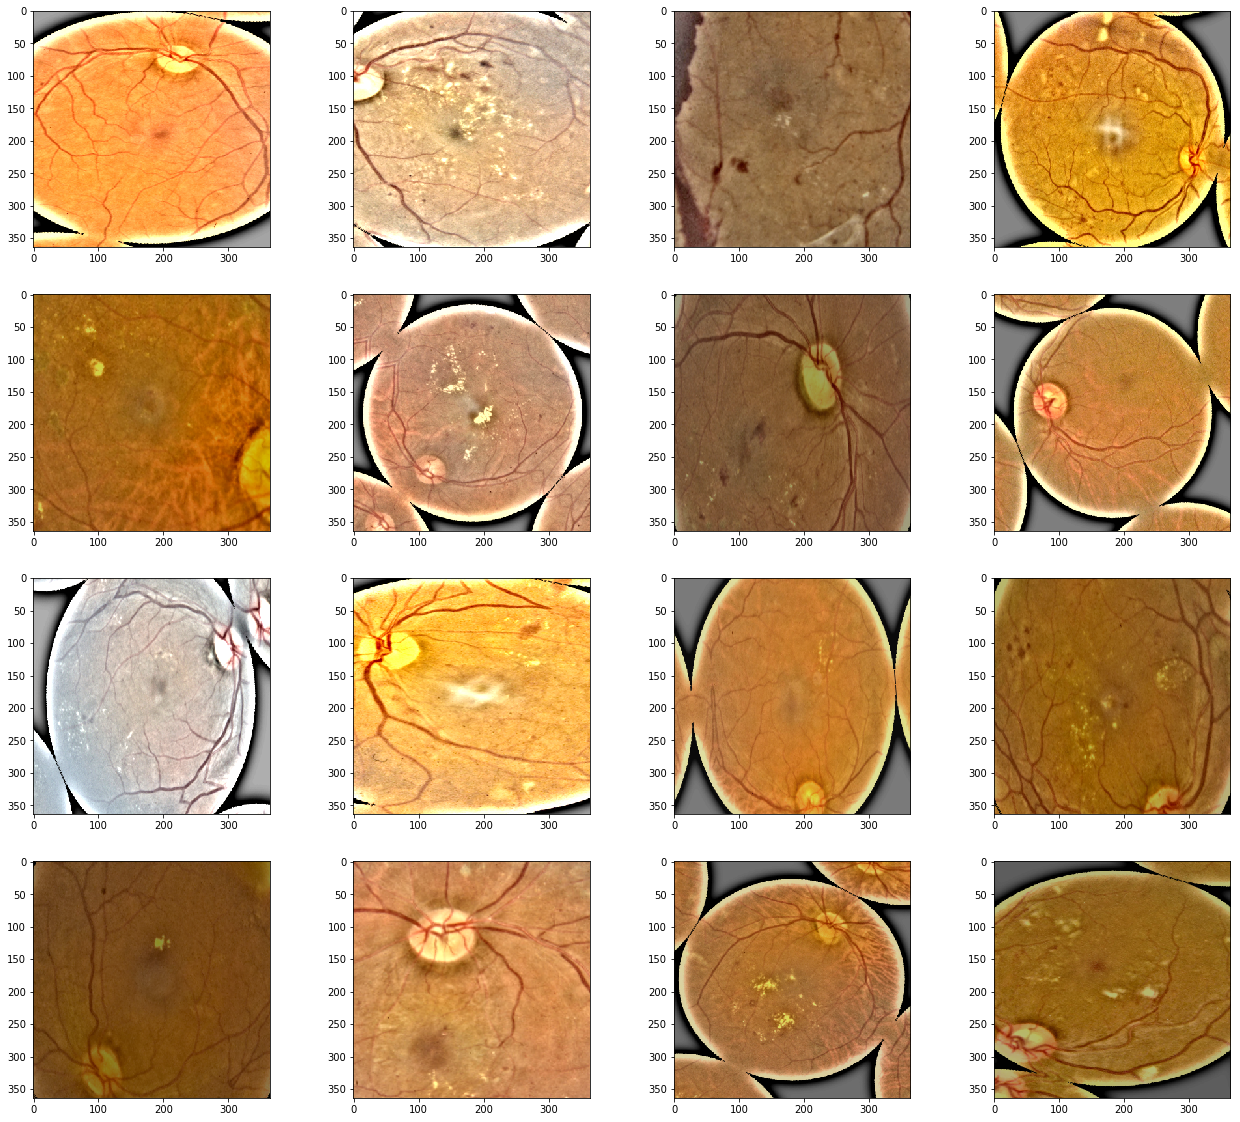

In [6]:
train_sample_gen, valid_sample_gen = generator(jitter=0.5)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [7]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 15
        y_pred     = []
        y_val      = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            y_pred.extend(label_convert(predictions > 0.5))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(val_kappa)
        print(confusion_matrix(y_val, y_pred))
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.84:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(f"{pre_process}-{val_kappa:.4f}.h5")


In [8]:
def create_model():
    
    model = Sequential()
    model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
#     model.add(DenseNet121(weights=None, 
                          include_top=False, 
                          input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()



W0816 06:54:44.107924 139871394985728 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 06:54:44.125651 139871394985728 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 06:54:44.131132 139871394985728 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 06:54:44.153258 139871394985728 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The n

In [ ]:
 for jitter in [0.4, 0.2, 0.1, 0.05]:
    
    model.compile(optimizer=Adam(lr=0.00005*jitter), loss='binary_crossentropy',  metrics=['accuracy'])
    
    print("           -----------------------------------", 
          jitter, "-----------------------------------")
    
    for even_distrib in [True, False]:
        
        for year in ["2019"]:

            print("           -   -   -   -   -   -   -   -   ", year, 
                  even_distrib, "-   -   -   -   -   -   -   -   -")
            
            # these need to be global for the kappa callback
            train_generator, valid_generator = generator(jitter=jitter, year=year, even_distrib=even_distrib)

            # Call backs during training            
            kappa_callbacks = Metrics(valid_generator)
            reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                           min_lr=1e-8, mode='auto', verbose=1)

            # train the model for 12 epochs
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                          validation_data=valid_generator,
                                          validation_steps=valid_generator.n // valid_generator.batch_size,
                                          epochs=3, workers=4, verbose=1,
                                          callbacks=[reduce_lr, kappa_callbacks],
                                         )
    
    gc.collect()

W0816 06:55:20.387535 139871394985728 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 06:55:20.398583 139871394985728 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


           ----------------------------------- 0.4 -----------------------------------
           -   -   -   -   -   -   -   -    2019 True -   -   -   -   -   -   -   -   -
Found 632 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Epoch 1/3
39/39 [==============================] - 107s 3s/step - loss: 0.6347 - acc: 0.6551 - val_loss: 0.5673 - val_acc: 0.7453
0.42409725133241516
[[ 0  0  0  0  0  0]
 [ 6 19 13  6  2  0]
 [ 2  8 15 13  9  0]
 [ 1  2  7 15 17  0]
 [ 2  3  5 18 26  0]
 [ 0  4 10 13 19  1]]
Epoch 2/3
39/39 [==============================] - 52s 1s/step - loss: 0.5093 - acc: 0.7597 - val_loss: 0.5197 - val_acc: 0.7710
0.5514441975730644
[[ 0  0  0  0  0  0]
 [ 3 20  9  7  4  1]
 [ 1 10  8 18  8  1]
 [ 0  2  7 10 23  3]
 [ 0  0  3  9 37  3]
 [ 0  1  5 10 22  7]]
Epoch 3/3
39/39 [==============================] - 49s 1s/step - loss: 0.4637 - acc: 0.7958 - val_loss: 0.4641 - val_acc: 0.8417
0.7362525358448406
[[ 0 

In [ ]:
model.save(f"{pre_process}-2019-run.h5")

# Compare the average of 5 randomised jitters to a non-jittered val

In [ ]:
# def compare_prediction_process(year="2019"):

#     _, valid_df = get_train_valid_df(year=year, even_distrib=False)
    
#     y_val  = valid_df.diagnosis.astype(int)

#     # with jitter
#     num = 7
#     prediction_lists = np.zeros((valid_df.index.size, num, 5))
#     for i in range(num):
#         datagen = datagen_with_flow(dataGenerator(0.03), valid_df, f"../aptos{year}/train_images/")
#         prediction_lists[:, i] = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)

#     predictions = np.median(prediction_lists, axis=1)
#     y_pred = label_convert(predictions > 0.5)
    
#     print("With jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
#     print(confusion_matrix(y_val, y_pred))
          
#     # no jitter
#     datagen = datagen_with_flow(dataGenerator(0), valid_df, f"../aptos{year}/train_images/")
#     predictions = model.predict_generator(generator=datagen, steps=len(datagen), workers=4, verbose=1)
#     y_pred = label_convert(predictions > 0.5)
    
#     print("With no jitter: ", cohen_kappa_score(y_val, y_pred, weights='quadratic'))
#     print(confusion_matrix(y_val, y_pred))
            
    
# compare_prediction_process("2019")
# gc.collect()